In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import transforms
import torch
from torchvision.transforms import functional as tvf
import torchvision
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import random
import scipy.ndimage.filters
import multiprocessing
from multiprocessing import Process
from multiprocessing import Queue 
import time
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
paths = {
"images_path" : "drive/My Drive/NNFL_project/VOC2012/JPEGImages",
"targets_path" : "drive/My Drive/NNFL_project/improved_contours",
"train_names_path" : "drive/My Drive/NNFL_project/VOC2012/ImageSets/Segmentation/train.txt",
"val_names_path" : "drive/My Drive/NNFL_project/VOC2012/ImageSets/Segmentation/val.txt",
"model_save_path": "drive/My Drive/NNFL_project/models"
}

for p in paths.values():
    if(os.path.exists(p) == False):
        print("path " , p , "does not exist")

In [3]:
"""
target_names = os.listdir(paths["targets_path"])

for name in target_names:
    if( "(" in name):
        path = os.path.join(paths["targets_path"], name)
        os.remove(path)
"""

'\ntarget_names = os.listdir(paths["targets_path"])\n\nfor name in target_names:\n    if( "(" in name):\n        path = os.path.join(paths["targets_path"], name)\n        os.remove(path)\n'

In [0]:
class dataloader:
    def __init__(self,paths):
        self.paths = paths
        self.train_images_pil = []
        self.train_tar_pil = []
        self.make_train_val_names()
        self.pointer = 0
        self.index_arr = [x for x in range(len(self.train_names))]

        
    def make_train_val_names(self):
        with open(paths["train_names_path"]) as handle:
            orignal_train_names = [x.split("\n")[0].strip() for x in handle]
        with open(paths["val_names_path"]) as handle:
            val_names = [x.split("\n")[0].strip() for x in handle]
        self.train_names = []
        classaug_imgs = os.listdir(self.paths["targets_path"])
        val_set =set(val_names)
        for name in classaug_imgs:
            name = name.split(".")[0]
            if name not in val_set:
                self.train_names.append(name)
        self.train_names += orignal_train_names

        self.train_names = list(set(self.train_names))
        self.val_names = list(val_set)


    def __len__(self):
        return len(self.train_names)

    def reset_loader(self):
        random.shuffle(self.index_arr)
        self.pointer = 0

    def transform(self, image_origin, mask_origin, mode, data_augmentation = "randomcrop"):
        image_res, mask_res = None, None
        totensor_op = transforms.ToTensor()
        color_op = transforms.ColorJitter(0.1, 0.1, 0.1)
        resize_op = transforms.Resize((224, 224))
        image_origin = color_op(image_origin)
      #  norm_op = transforms.Normalize(mean =[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

        if mode == 'val' or mode == 'predict':
            image_res = totensor_op(image_origin)
            mask_res = totensor_op(mask_origin)
        elif mode == 'train':
            if data_augmentation == 'randomcrop':
                if image_origin.size[0] < 224 or image_origin.size[1] < 224:
                    #padding-val:
                    val = int(np.array(image_origin).sum() / image_origin.size[0] / image_origin.size[1])
                    padding_width = 224-min(image_origin.size[0],image_origin.size[1])
                    padding_op = transforms.Pad(padding_width,fill=val)
                    image_origin = padding_op(image_origin)
                    padding_op = transforms.Pad(padding_width, fill=0)
                    mask_origin = padding_op(mask_origin)
                i, j, h, w = transforms.RandomCrop.get_params(
                    image_origin, output_size=(224, 224)
                )
                image_res = totensor_op(tvf.crop(image_origin, i, j, h, w))
                mask_res = totensor_op(tvf.crop(mask_origin, i, j, h, w))

            elif data_augmentation == 'resize':
                image_res = totensor_op(resize_op(image_origin))
                mask_res = totensor_op(resize_op(mask_origin))
      #  image_res = norm_op(image_res)
     
        return image_res, mask_res


    def _make_dicts(self):
        count= 0
        for img_name in self.train_names:
            count += 1
            print(count)
            img_path = os.path.join(self.paths["images_path"] , img_name + ".jpg")
            mask_path = os.path.join(self.paths["targets_path"] , img_name + ".png")
            img = Image.open(img_path)
            tar = Image.open(mask_path)
            self.train_images_pil.append(img)
            self.train_tar_pil.append(tar)
        
    
    
    def get_next_mini_batch(self, index_given= None):
            if(self.pointer == len(self.train_names)):
                self.reset_loader()
            if(index_given == None):
                index = self.pointer
            else:
                index = index_given
            self.pointer += 1
            img_name = self.train_names[index]
            img_path = os.path.join(self.paths["images_path"] , img_name + ".jpg")
            mask_path = os.path.join(self.paths["targets_path"] , img_name + ".png")
            img = Image.open(img_path)
            tar = cv2.imread(mask_path,0)
            tar = Image.fromarray(tar)
            img_batch = torch.empty(8,3,224,224)
            tar_batch = torch.empty(8,1,224,224)

            for i in range(4):
                img_batch[i] , tar_batch[i] = self.transform(img,tar,"train")
            img = tvf.hflip(img)
            tar = tvf.hflip(tar)

            for i in range(4,8):
                img_batch[i] , tar_batch[i] = self.transform(img,tar,"train")

           # tar_batch[tar_batch > .9] = 1
           # tar_batch[tar_batch <= .9] = 0
            return img_batch , tar_batch
            
            
    def get_next_batch(self, batch_size):
        index = np.random.randint(0, len(self.train_names), size = batch_size)
        img_batch = torch.empty(batch_size,3,224,224)
        tar_batch = torch.empty(batch_size,1,224,224)

        for i in range(batch_size):
            img_name = self.train_names[index[i]]
            img_path = os.path.join(self.paths["images_path"] , img_name + ".jpg")
            mask_path = os.path.join(self.paths["targets_path"] , img_name + ".png")
            img = Image.open(img_path)
            tar = cv2.imread(mask_path,0)
            tar = Image.fromarray(tar)
            
            if(random.random() > .5):
                img = tvf.hflip(img)
                tar = tvf.hflip(tar)
            img_batch[i] , tar_batch[i] =  self.transform(img,tar,"train")

        return img_batch, tar_batch

    


data_object = dataloader(paths)

In [0]:
vgg16 =  torchvision.models.vgg16(pretrained=True)

In [0]:
# Extraction till the first fully connected layer of vgg16 
class Reshape(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self ,x):
        return x.view(x.size(0),-1)


vgg = list(vgg16.children())[0]
"""list(vgg16.children())[1] ,"""
vgg = nn.Sequential(*vgg,  Reshape() ,list(vgg16.children())[2][0] )
for p in vgg.parameters():
    p.requires_grad = False



In [7]:
# This gives us these 
for i,name in enumerate(list(vgg.children())):
    print(i,name)
# Notice that we need Maxpool2d to return indices eevery time in order for the network to perform unpooling
# So we will judt jo this manually !!!! :(

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
17 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 ReLU(inplace=True)
19 Conv2d(512, 512, kernel_size=(3, 3)

In [0]:
def plot_hist(tensor):
    tensor = tensor.cpu().numpy()
    tensor = tensor[(tensor <= .5) & (tensor >= -.5) ]
    plt.hist(tensor.reshape(-1))
    plt.show()

In [0]:
class Encoder(nn.Module):
    def __init__(self, vgg):
        super().__init__()
        self.vgg = list(vgg.children())
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.conv6 = nn.Conv2d(in_channels = 512, out_channels = 4096, kernel_size = 3, stride=1, padding = 1)
    def forward(self,x):

        pooling_info = {}
        layer_info = {}
        # Starting conv1
        x = self.vgg[0](x)
 
        x = self.vgg[1](x)
        x = self.vgg[2](x)
        x = self.vgg[3](x)
        shape = x.shape
        
        layer_info[1] = {"value": x}
        x , ind = self.pool1(x)
        pooling_info[1] = {"kernel_size" : 2, "stride": 2, "padding": 0 ,"output_size": shape,"indices":ind}
        

        # start conv2
        x = self.vgg[5](x)
        x = self.vgg[6](x)
        x = self.vgg[7](x)
        x = self.vgg[8](x)

        shape = x.shape
        layer_info[2] = {"value": x}
        x , ind = self.pool2(x)
        pooling_info[2] = {"kernel_size" : 2, "stride": 2, "padding": 0 ,"output_size": shape,"indices":ind}



        # start conv3
        x = self.vgg[10](x)
        x = self.vgg[11](x)
        x = self.vgg[12](x)
        x = self.vgg[13](x)
        x = self.vgg[14](x)
        x = self.vgg[15](x)

        shape = x.shape
        layer_info[3] = {"value": x}
        x , ind = self.pool3(x)
        pooling_info[3] = {"kernel_size" : 2, "stride": 2, "padding": 0 ,"output_size": shape,"indices":ind}
  

        x = self.vgg[17](x)
        x = self.vgg[18](x)
        x = self.vgg[19](x)
        x = self.vgg[20](x)
        x = self.vgg[21](x)
        x = self.vgg[22](x)


        shape = x.shape
        layer_info[4] = {"value": x}
        x , ind = self.pool4(x)
        pooling_info[4] = {"kernel_size" : 2, "stride": 2, "padding": 0 ,"output_size": shape,"indices":ind}
      


        x = self.vgg[24](x)
        x = self.vgg[25](x)
        x = self.vgg[26](x)
        x = self.vgg[27](x)
        x = self.vgg[28](x)
        x = self.vgg[29](x)

        shape = x.shape
        layer_info[5] = {"value": x}
        x , ind = self.pool5(x)
        pooling_info[5] = {"kernel_size" : 2, "stride": 2, "padding": 0 ,"output_size": shape,"indices":ind}
    
        x = self.conv6(x)
      #  x = self.vgg[31](x)
      #  x = self.vgg[32](x)
        
        return x , pooling_info, layer_info
         




In [0]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.dconv6 = nn.Conv2d(in_channels = 4096, out_channels = 512, kernel_size = 1, stride=1)
       
        self.deconv5 = nn.ConvTranspose2d(in_channels = 512, out_channels = 512, kernel_size = 5, padding =2)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 5 , padding = 2)
        self.deconv3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 5 ,padding = 2)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 5 , padding = 2)
        self.deconv1 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 5 ,padding = 2)
        self.pred = nn.ConvTranspose2d(in_channels = 32, out_channels = 1, kernel_size = 5, padding = 2)

    def forward(self,encoder_out):
        x = encoder_out[0]
        dicts = encoder_out[1]


        x = self.dconv6(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_unpool2d(x, **dicts[5])

        
     
        x = self.deconv5(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_unpool2d(x, **dicts[4])  # Indices 512


        x = self.deconv4(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_unpool2d(x, **dicts[3])  # Indices 256


        x = self.deconv3(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_unpool2d(x, **dicts[2])  # Indices 128


        x = self.deconv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_unpool2d(x, **dicts[1])  # Indices 64
        x = self.deconv1(x)
        x = nn.functional.relu(x)

        x = self.pred(x)

        x = torch.sigmoid(x)
        return x

In [0]:
class U_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels = in_channels, out_channels = in_channels, kernel_size = 2,stride = 2)
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = in_channels,kernel_size = 2)
        self.conv2 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels,kernel_size = 2,padding = 1)

    def forward(self,x, add  = None):
        x = self.upsample(x)
        x = nn.functional.relu(x)
        if(add != None):
            x += add
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        return nn.functional.relu(x)

class Decoder1(nn.Module):
    def __init__(self):
        super().__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv1 = nn.Conv2d(in_channels = 4096, out_channels = 512, kernel_size = 1, stride=1)
        # size is (bs,512,7,7)
        self.U_block1 = U_block(512,512) # add layer 5
        # size is (bs,512,14,14)
        self.U_block2 = U_block(512,256)  # add layer 4
        # size is (bs,512,28,28)
        self.U_block3 = U_block(256,128) # add layer 3
        # size i (bs,128,56,56)

        self.U_block4 = U_block(128,64) # add layer 2
        # size is (bs,64,122,122)

        self.U_block5 = U_block(64,32) # add layer 1
        # size is (bs,32,224,224)
        self.pred = nn.Conv2d(in_channels = 32, out_channels = 1, kernel_size = 3, padding = 1)

    def forward(self,encoder_out):
        x = encoder_out[0]
        layer_info = encoder_out[2]
        x = self.conv1(x)
        x = nn.functional.relu(x)


        x = self.U_block1(x,layer_info[5]["value"])
        x = self.U_block2(x,layer_info[4]["value"])
        x = self.U_block3(x,layer_info[3]["value"])
        x = self.U_block4(x,layer_info[2]["value"])
        x = self.U_block5(x,layer_info[1]["value"])

        x = self.pred(x)

        x = torch.sigmoid(x)
        return x

In [0]:
class countour_detector(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.encoder = Encoder(backbone.to(device)).to(device)
        self.decoder = Decoder().to(device)

    def forward(self,x):
        x = self.encoder(x)
        return self.decoder(x)

In [0]:
model = countour_detector(vgg)
model.load_state_dict(torch.load(os.path.join(paths["model_save_path"],"model7.pth")))
model = model.to(device)

In [0]:
class trainer:
    def __init__(self, model):
        self.model = model.to(device)
        self.model.train()
        self.lr = 1e-4
        self.optimizer = torch.optim.Adam([x for x in list(self.model.parameters()) if x.requires_grad == True], lr=self.lr)
        self.bce =  nn.BCELoss(reduction = "none")
        self.mse = nn.MSELoss(reduction = "none")
        self.loss_array = []


    def loss(self,outputs, targets):
        weights = torch.empty_like(targets).to(device)
        weights[targets >= .98] = 10
        weights[targets < .98] = 1
        loss = F.binary_cross_entropy(outputs, targets, weights)



        return loss 

    def train(self, data):
            total_loss = 0
            images, targets = data[0], data[1]
            images = images.to(device)
            targets = targets.to(device)
            pred = self.model(images)
            loss = self.loss(pred , targets)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            print("loss = ",loss.item())

    def save_model(self , name):
         torch.save(self.model.cpu().state_dict(), os.path.join(paths["model_save_path"] , "model" + name + ".pth"))
         self.model.to(device)





In [0]:
T = trainer(model)

In [0]:
Q = Queue()
def producer(times, dataobject, Q, batch_size = None):
    while(times > 0):
        while(Q.qsize() > 100):
            time.sleep(5)
            continue
        index = random.randint(0, len(dataobject) - 1)
        Q.put(dataobject.get_next_mini_batch(index))
        times -= 1
    Q.put("End")
    time.sleep(50)




In [0]:
class multiprocess_control:
    def __init__(self, dataobject, workers, produce_func, shared_Q, epochs_desired, train_object):
        self.dataobject = dataobject
        self.workers = workers
        self.produce_func = produce_func
        self.shared_Q = shared_Q
        self.desired_epochs = epochs_desired
        self.train_object = train_object

    def spawn_producers(self, batch_size= None):
        times = len(self.dataobject)*self.desired_epochs
        if(times < self.workers):
            print("too many workers")
            return None
        produce_arr =  []
        
        for i in range(self.workers):
            if(i == self.workers - 1):
                reps = times//self.workers + self.desired_epochs%self.workers
            else:
                reps = times//self.workers
            produce_arr.append(Process(target = self.produce_func, args = (reps  ,self.dataobject,self.shared_Q,batch_size,)))
        
        return produce_arr

    
    def start_training(self, batch_size= None):
        arr = self.spawn_producers(batch_size)
        for p in arr:
            p.start()
        time.sleep(1)
        end_count = 0
        iters = 0
        offset = 7
        while(end_count < self.workers):
            if(self.shared_Q.empty()):
                time.sleep(5)
                continue
            else:
                data = Q.get()
                if(data == "End"):
                    print("Hello")
                    end_count += 1
                    continue
                else:
                    iters += 1
                    if(iters%len(self.dataobject) == 0):
                        print("Saving Model")
                        self.train_object.save_model(str(iters//len(self.dataobject) + offset))
                       
                    print(iters, end = " ")
                    self.train_object.train(data)
        

        for p in arr:
            p.join()






In [0]:
multi = multiprocess_control(data_object,workers = 17,produce_func = producer, shared_Q = Q,epochs_desired = 27,train_object =T)

In [0]:
multi.start_training()

loss =  0.1666630357503891
10416 loss =  0.22819660604000092
10417 loss =  0.11756916344165802
10418 loss =  0.27751100063323975
10419 loss =  0.15654924511909485
10420 loss =  0.46207505464553833
10421 loss =  0.3006734251976013
10422 loss =  0.36913222074508667
10423 loss =  0.2357913702726364
10424 loss =  0.18587909638881683
10425 loss =  0.29570573568344116
10426 loss =  0.19434496760368347
10427 loss =  0.16306574642658234
10428 loss =  0.597903311252594
10429 loss =  0.22551125288009644
10430 loss =  0.047640640288591385
10431 loss =  0.28013691306114197
10432 loss =  0.19650150835514069
10433 loss =  0.15486639738082886
10434 loss =  0.12125649303197861
10435 loss =  0.5974899530410767
10436 loss =  0.39794114232063293
10437 loss =  0.18743301928043365
10438 loss =  0.14018838107585907
10439 loss =  0.1108182966709137
10440 loss =  0.1658416986465454
10441 loss =  0.13116593658924103
10442 loss =  0.4453083574771881
10443 loss =  0.2786557078361511
10444 loss =  0.0918119177222

In [0]:
a,b = data_object.get_next_batch(10)


In [0]:
bb = model(a[0:1].to(device))

In [0]:
bb = bb.detach().cpu().numpy()[0]

In [0]:
bb = bb[0]

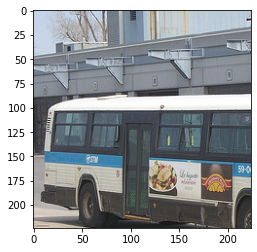

In [0]:
a =  a[0].numpy()
a = np.rollaxis(a,2)
a = np.rollaxis(a,2)
plt.imshow(a)

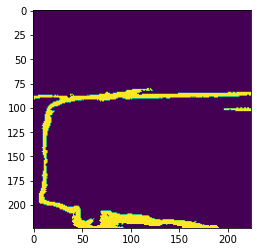

In [0]:
bb[bb > .5] = 1
bb[bb <= .5] = 0
plt.imshow(bb)

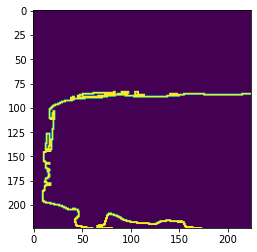

In [0]:
b = b[0][0].numpy()
plt.imshow(b)

In [0]:
test_path = os.path.join(paths["images_path"], "2007_001458.jpg")

In [0]:
test_img = Image.open(test_path)

In [0]:
test_img = np.array(test_img)

In [0]:
test_img = np.rollaxis(test_img , 2)

In [0]:
test_img = torch.tensor(test_img).unsqueeze(0).to(device).float()/255

In [0]:
res = model(test_img)

In [0]:
a = res.cpu().detach().numpy()[0][0]

In [0]:
a[a >= 5] = 1
a[a < .5] = 0

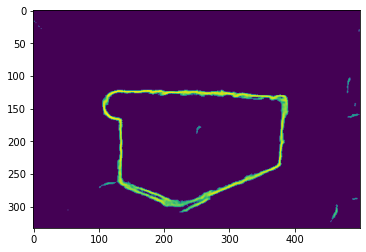

In [0]:
plt.imshow(a)